# SLAM experiments

In [29]:
# Importing the libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.image as mpimg
import cv2
import time
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN

# Plotting settings
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

## The setup

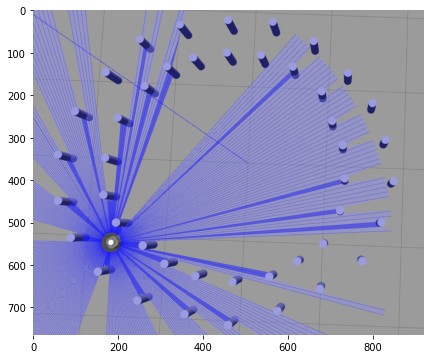

In [21]:
# Show the image
img = mpimg.imread('/home/valigatotus/Documents/github/LiDAR-FSAE/docu/hidden/round_circuit.png')
plt.imshow(img)

## Loading map

In [63]:
# Loading the map from a pickle file
with open('../map_data2.pickle', 'rb') as f:
    map_data = pickle.load(f)

# Map parameters
resolution, xorigin, yorigin = 0.05000000074505806, -0.803898811340332, -1.9500000000000002
extent=[xorigin, xorigin + map_data.shape[1]*resolution, yorigin, yorigin + map_data.shape[0]*resolution]

map_data.shape

(110, 104)

### Plotting Occupancy-grid

(-0.803898811340332,
 4.396101266145706,
 -1.9500000000000002,
 3.5500000819563864)

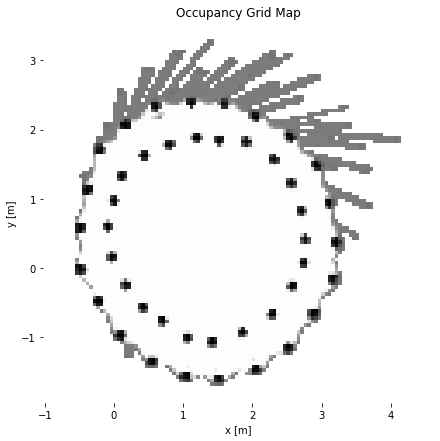

In [24]:
# Plotting the map
fig_occupancy, ax = plt.subplots()
ax.imshow(map_data, cmap='gray', origin='lower', extent=extent)
ax.set_title('Occupancy Grid Map')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')

### Map values exploration

Total count of pixels:  11440
	 White pixels percentage (>99):  86.24125874125875 %
	 Gray pixels percentage (99>x>threshold) 11.04020979020979 %
	 Black pixels percentage (<threshold):  2.6486013986013983 %


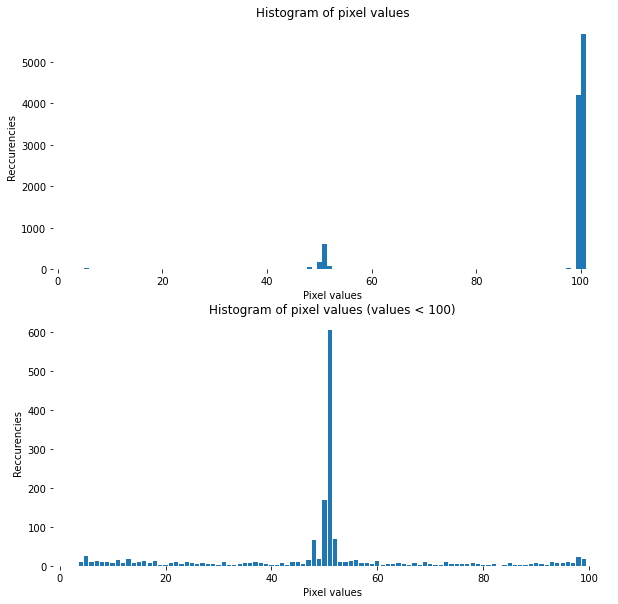

In [25]:
threshold = 42
values, counts = np.unique(map_data, return_counts=True) 
values_counts = np.array([values, counts]).T

# Plotting the bar charts of pixel values and their reccurencies

fig_bar, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].hist(map_data.flatten(), bins=100)
ax[0].set_title('Histogram of pixel values')
ax[0].set_xlabel('Pixel values')
ax[0].set_ylabel('Reccurencies')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[1].bar(values_counts[values_counts[:,0]<100,0], values_counts[values_counts[:,0]<100,1])
ax[1].set_title('Histogram of pixel values (values < 100)')
ax[1].set_xlabel('Pixel values')
ax[1].set_ylabel('Reccurencies')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Printing the percentage of white, gray and black pixels
total_count = np.sum(counts)
print('Total count of pixels: ', total_count)
print('\t White pixels percentage (>99): ', np.sum(values_counts[values_counts[:,0]>99,1])/total_count*100, '%')
print('\t Gray pixels percentage (99>x>threshold)', np.sum(values_counts[(values_counts[:,0]>threshold) & (values_counts[:,0]<100),1])/total_count*100, '%')
print('\t Black pixels percentage (<threshold): ', np.sum(values_counts[values_counts[:,0]<threshold,1])/total_count*100, '%')

### Filtering the map
Keeping only peaks, which are represented with black pixels (value near zero)

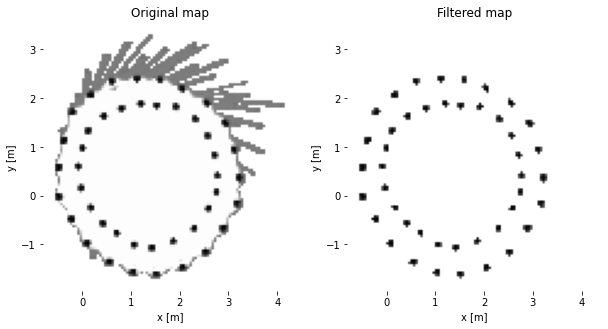

In [65]:
# import cv2
# # Thresholding the map
# map_data_filtered = map_data.copy().astype(np.uint8)
# map_data_filtered = cv2.threshold(map_data_filtered, threshold, white, cv2.THRESH_BINARY)[1]
# # Plotting both original and filtered map
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(map_data, cmap='gray', origin='lower', extent=extent)
# ax[0].set_title('Original map')
# ax[1].imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
# ax[1].set_title('Filtered map')

# Dark gray values on the map are close to 0 and represent the cones on the map
threshold ,white = 42, 101
map_data_filtered = map_data.copy()
map_data_filtered[map_data > threshold] = white

# Plotting both original and filtered map
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(map_data, cmap='gray', origin='lower', extent=extent)
ax[0].set_title('Original map')
ax[0].set_xlabel('x [m]'), ax[0].set_ylabel('y [m]')
ax[1].imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
ax[1].set_title('Filtered map')
ax[1].set_xlabel('x [m]'), ax[1].set_ylabel('y [m]')

## Clustering

### Meansshift clustering
Mean-shift clustering is a non-parametric, density-based clustering algorithm that can be used to identify clusters in a dataset.

Time elapsed:  0.22761964797973633 s
Number of estimated clusters:  44


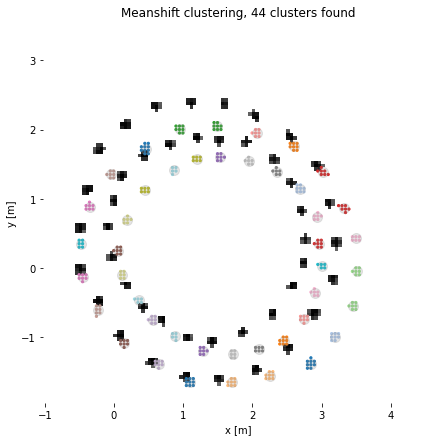

In [64]:
# Getting the cartesian coordinates of the black pixels
x, y = np.where(map_data < threshold)
x, y = (x*resolution + xorigin, y*resolution + yorigin)
points = np.array([x, y]).T

# Meanshift clustering
start = time.time()
bandwidth = estimate_bandwidth(points, quantile=0.025, n_samples=80)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
end = time.time()
print('Time elapsed: ', end-start, 's')

# Plotting the results
fig, ax = plt.subplots()
ax.imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
ax.scatter(points[:,0], points[:,1], c=labels, s=5, cmap='tab20')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], c='gray', marker='o', s=100, alpha=0.2)
ax.set_title('Meanshift clustering, %i clusters found' % len(np.unique(labels)))
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')

# Printing the number of clusters
n_clusters_ = len(np.unique(labels))
print('Number of estimated clusters: ', n_clusters_)

### DBSCAN

Time execution:  0.5421333312988281
Number of estimated clusters:  44


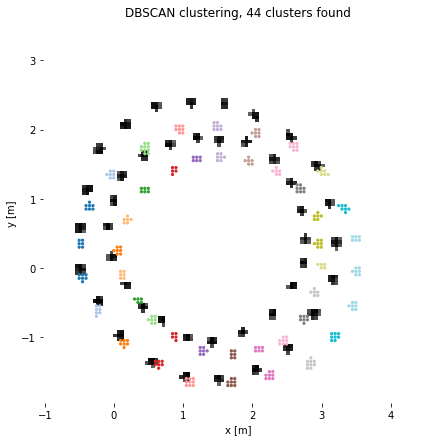

In [61]:
# DBSCAN clustering
start = time.time()
db = DBSCAN(eps=0.1, min_samples=3).fit(points)
labels = db.labels_
end = time.time()
print('Time execution: ', end - start)

# Plotting the results
fig, ax = plt.subplots()
ax.imshow(map_data_filtered, cmap='gray', origin='lower', extent=extent)
ax.scatter(points[:,0], points[:,1], c=labels, s=5, cmap='tab20')
ax.set_title('DBSCAN clustering, %i clusters found' % len(set(labels)))
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')

# Printing the number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of estimated clusters: ', n_clusters_)


### Contouring technique

Number of centroids found:  44


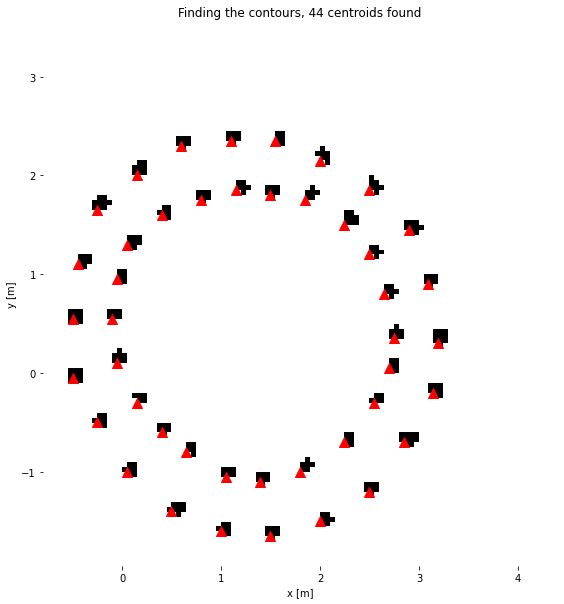

In [67]:
# Finding the centroids 
map_data_t = cv2.threshold(map_data.astype(np.uint8), threshold, white, cv2.THRESH_BINARY)[1]
contours, hierarchy = cv2.findContours(map_data_t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[1:]
centroids = []

for i in range(len(contours)):
    M = cv2.moments(contours[i])
    cx = int(M['m10']/M['m00']) * resolution + xorigin
    cy = int(M['m01']/M['m00']) * resolution + yorigin
    centroids.append([cx, cy])

# Plotting the centroids
fig_centroids, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent)
ax.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], c='r', marker='^', s=100)
ax.set_title('Finding the contours, %i centroids found' % len(contours))
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')

# Printing the number of centroids found
print('Number of centroids found: ', len(contours))

#### Blob-detection

In [ ]:
# Using blob detection to find the centroids

params = cv2.SimpleBlobDetector_Params()

# Changing thresholds
params.minThreshold = 0
params.maxThreshold = 42

# Filtering by Area.
params.filterByArea = True
params.minArea = 100

# Filtering by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filtering by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filtering by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params) 
keypoints = detector.detect(map_data.astype(np.uint8)) 

# Plotting the keypoints
keypoints

()

## Track definition

Nearest neighbours, convexhulls, curve fitting? 

### Connecting the 3 nearest neighbours


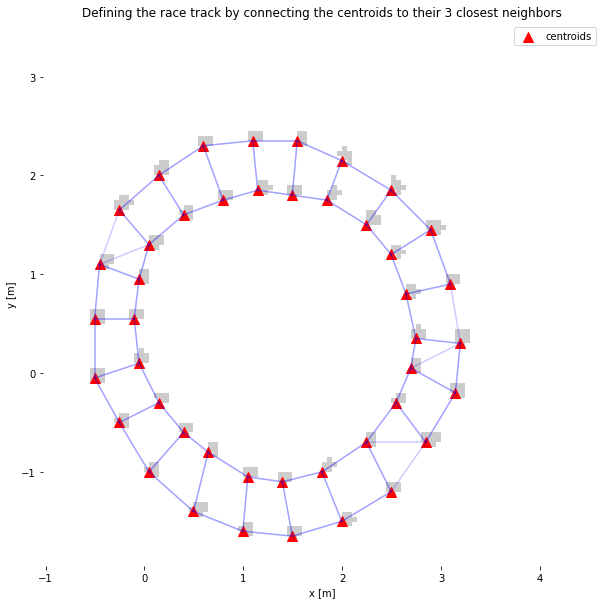

In [68]:
from scipy.spatial.distance import cdist

distances = cdist(centroids, centroids)

# Setting the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# Finding the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], c='r', marker='^', s=100, label='centroids')
for i in range(len(centroids)):
    for j in range(3):
        ax.plot([centroids[i][0], centroids[closest_centroids[i][j]][0]], [centroids[i][1], centroids[closest_centroids[i][j]][1]], 'b', alpha=0.2)
ax.set_title('Defining the race track by connecting the centroids to their 3 closest neighbors')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

### Nearest neighbours and greatest angles

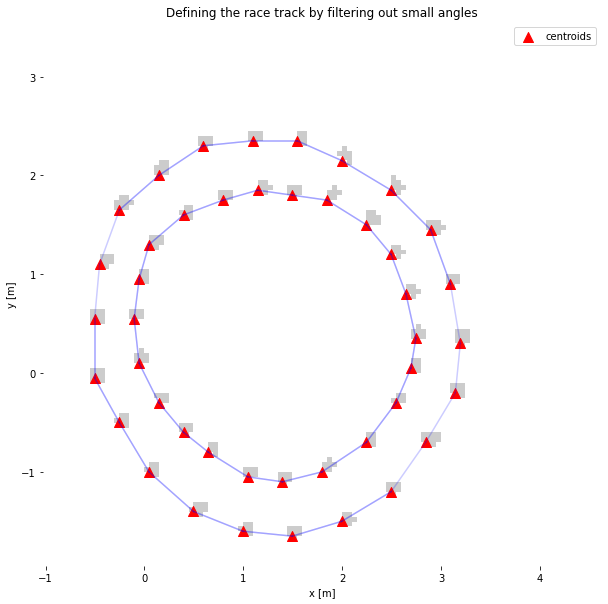

In [69]:
centroids = np.array(centroids) # convert centroids list to numpy array
distances = cdist(centroids, centroids)

# set the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# find the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='^', s=100, label='centroids')

for i in range(len(centroids)):
    angles = []
    for j in range(3):
        vec1 = centroids[closest_centroids[i][j]] - centroids[i]
        vec2 = centroids[closest_centroids[i][(j+1)%3]] - centroids[i]
        # calculate angle between the two vectors
        angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
        angles.append(angle)
    # get index of maximum angle
    max_angle_idx = np.argmax(angles)
    # plot line corresponding to the maximum angle
    if angles[max_angle_idx] >= np.deg2rad(130):
        ax.plot([centroids[i][0], centroids[closest_centroids[i][max_angle_idx]][0]], [centroids[i][1], centroids[closest_centroids[i][max_angle_idx]][1]], 'b', alpha=0.2)
        
        # remove the point that was already used for the first line
        other_points = np.delete(centroids[closest_centroids[i]], max_angle_idx, axis=0)

        # calculate angles between the remaining points and the first line
        angles_to_first_line = []
        for j in range(2):
            vec1 = other_points[j] - centroids[i]
            vec2 = centroids[closest_centroids[i][max_angle_idx]] - centroids[i]
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles_to_first_line.append(angle)
        # get index of maximum angle
        max_angle_idx = np.argmax(angles_to_first_line)
        # plot line corresponding to the maximum angle
        if angles_to_first_line[max_angle_idx] >= np.deg2rad(100):
            ax.plot([centroids[i][0], other_points[max_angle_idx][0]], [centroids[i][1], other_points[max_angle_idx][1]], 'b', alpha=0.2)

ax.set_title('Defining the race track by filtering out small angles')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

### Convex Hulls

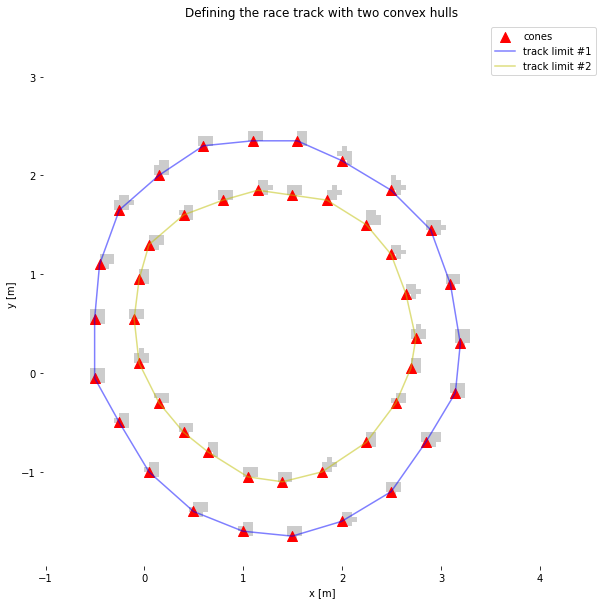

In [70]:
centroids = np.array(centroids) # converting centroids list to numpy array
distances = cdist(centroids, centroids)

# setting the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# finding the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='^', s=100, label='cones')

# first convex hull with all the centroids
hull_all = ConvexHull(centroids)

# getting the indices of the points that form the convex hull
hull_indices_all = hull_all.vertices.tolist()
# add the first point to the end to close the loop
hull_indices_all.append(hull_indices_all[0])

# plotting the first convex hull
ax.plot(centroids[hull_indices_all, 0], centroids[hull_indices_all, 1], 'b', alpha=0.5, label='track limit #1')

# get the indices of the points not included in the first convex hull
remaining_indices = np.setdiff1d(np.arange(len(centroids)), hull_indices_all[:-1])

# second convex hull with the remaining centroids
hull_remaining = ConvexHull(centroids[remaining_indices])

# getting the indices of the points that form the second convex hull
hull_indices_remaining = remaining_indices[hull_remaining.vertices].tolist()
# adding the first point to the end to close the loop
hull_indices_remaining.append(hull_indices_remaining[0])

# plotting the second convex hull
ax.plot(centroids[hull_indices_remaining, 0], centroids[hull_indices_remaining, 1], 'y', alpha=0.5, label='track limit #2')

ax.set_title('Defining the race track with two convex hulls')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

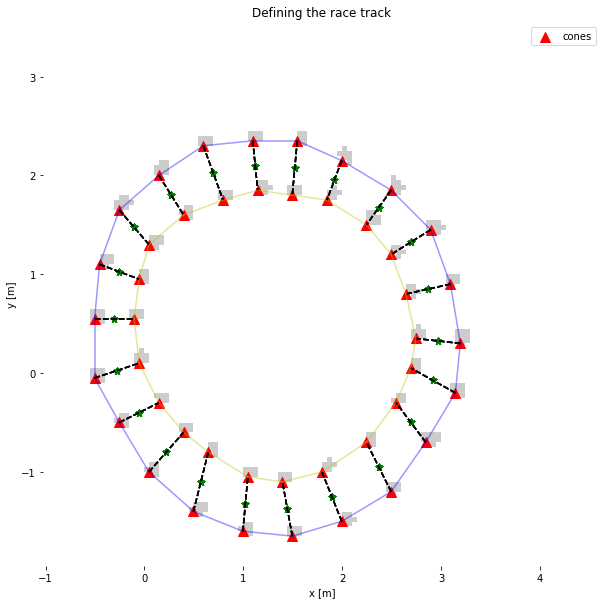

In [47]:
centroids = np.array(centroids) # convert centroids list to numpy array
distances = cdist(centroids, centroids)

# set the diagonal elements to a very large value to avoid connecting a centroid to itself
np.fill_diagonal(distances, np.inf)

# find the index of the 3 closest centroids for each centroid
closest_centroids = np.argsort(distances, axis=1)[:, :3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)
ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='^', s=100, label='cones')

# perform convex hull on all centroids
hull = ConvexHull(centroids)
for simplex in hull.simplices:
    ax.plot(centroids[simplex, 0], centroids[simplex, 1], 'b', alpha=0.4)

# find centroids not in the first hull
not_in_hull = centroids[~np.in1d(np.arange(len(centroids)), hull.vertices)]
# perform convex hull on centroids not in the first hull
hull2 = ConvexHull(not_in_hull)
for simplex in hull2.simplices:
    ax.plot(not_in_hull[simplex, 0], not_in_hull[simplex, 1], 'y', alpha=0.4)

    # plot dotted line between the two hulls
    for v in hull.vertices:
        # find closest point in second hull
        closest_point_idx = np.argmin(np.linalg.norm(not_in_hull - centroids[v], axis=1))
        # plot dotted line
        ax.plot([centroids[v][0], not_in_hull[closest_point_idx][0]], [centroids[v][1], not_in_hull[closest_point_idx][1]], 'k--', alpha=0.2)
        # and plot the midpoint of the line
        ax.scatter((centroids[v][0] + not_in_hull[closest_point_idx][0]) / 2, (centroids[v][1] + not_in_hull[closest_point_idx][1]) / 2, c='g', marker='*', s=50)

ax.set_title('Defining the race track')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()

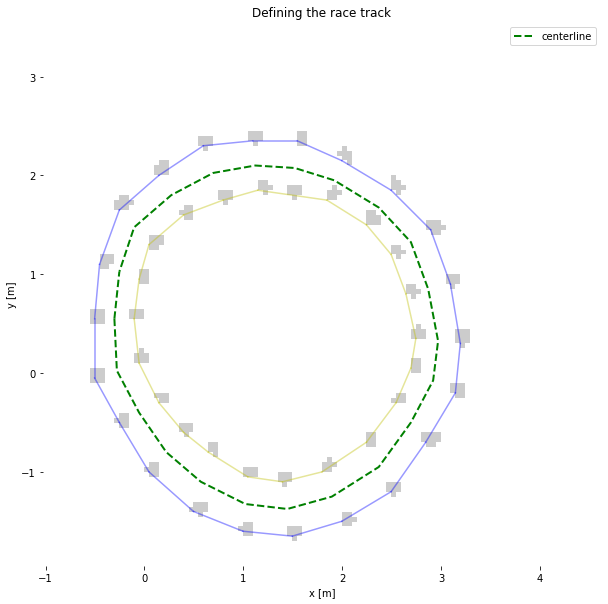

In [71]:
# import polygon class
from matplotlib.patches import Polygon

# calculate the centerline between the two hulls
centerline = []
for i in range(len(hull.vertices)):
    p1 = centroids[hull.vertices[i]]
    p2 = not_in_hull[np.argmin(np.linalg.norm(not_in_hull - p1, axis=1))]
    centerline.append((p1 + p2) / 2)

centerline = np.array(centerline)

# plot the costmap
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(map_data_t, cmap='gray', origin='lower', extent=extent, alpha=0.2)

# plot the track limits
for simplex in hull.simplices:
    ax.plot(centroids[simplex, 0], centroids[simplex, 1], 'b', alpha=0.4)
for simplex in hull2.simplices:
    ax.plot(not_in_hull[simplex, 0], not_in_hull[simplex, 1], 'y', alpha=0.4)

# plot the centerline
ax.plot(centerline[:, 0], centerline[:, 1], 'g--', linewidth=2)
# close the loop of the centerline
ax.plot([centerline[0, 0], centerline[-1, 0]], [centerline[0, 1], centerline[-1, 1]], 'g--', linewidth=2, label='centerline')

ax.set_title('Defining the race track')
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.axis('equal')
ax.legend()